<a href="https://colab.research.google.com/github/ShangWeiKuo/ShangWeiKuo-2022_Advance-offer/blob/master/Python/Classification/Binary/Casting/Casting_binary_classification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_keras_vis

     |████████████████████████████████| 53 kB 1.4 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.layers import Input, InputLayer, Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
train_path = '/content/drive/MyDrive/Anomaly detection/casting_data/train'
test_path = '/content/drive/MyDrive/Anomaly detection/casting_data/test'

In [4]:
BATCH_SIZE = 32

In [5]:
train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             validation_split=0.3)

test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

training_set = train.flow_from_directory(train_path, 
                      target_size=(224, 224), 
                      class_mode = 'binary', 
                      classes=['ok_front', 'def_front'], 
                      shuffle=True, 
                      batch_size=BATCH_SIZE,
                      color_mode="grayscale",
                      subset='training')

val_set = train.flow_from_directory(train_path, 
                   target_size=(224, 224), 
                   class_mode = 'binary', 
                   classes=['ok_front', 'def_front'], 
                   shuffle=False, 
                   batch_size=BATCH_SIZE,
                   color_mode="grayscale",
                   subset='validation')

test_set = test.flow_from_directory(test_path, 
                   target_size=(224, 224), 
                   class_mode = 'binary', 
                   classes=['ok_front', 'def_front'], 
                   shuffle=False, 
                   batch_size=BATCH_SIZE,
                   color_mode="grayscale")

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [6]:
training_set.class_indices

{'def_front': 1, 'ok_front': 0}

In [7]:
X_train, y_train = training_set.next()

In [8]:
train_def_idx = np.where(y_train == 1)
train_ok_idx = np.where(y_train == 0)

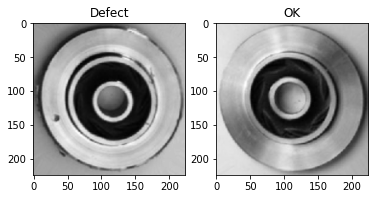

In [9]:
pic1 = plt.subplot(1, 2, 1)
pic1.imshow(X_train[train_def_idx][0].reshape((X_train.shape[1], X_train.shape[2])), cmap="gray")
pic1.set_title("Defect")
pic2 = plt.subplot(1, 2, 2)
pic2.imshow(X_train[train_ok_idx][0].reshape((X_train.shape[1], X_train.shape[2])), cmap="gray")
pic2.set_title("OK")
plt.show()

In [10]:
### batch-size = 32
### range的部分要除以batch否則後面的grad-cam會出現格式錯誤的訊息
### 取得test資料的圖片內容與標籤
test_set.reset()
X_test, y_test = next(test_set)
for i in tqdm(range((test_set.n//BATCH_SIZE)-1)): #1st batch is alread fetched before the for loop
  img, label = next(test_set)
  X_test = np.append(X_test, img, axis=0)
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 21/21 [01:12<00:00,  3.45s/it]

(704, 224, 224, 1) (704,)


In [11]:
test_def_idx = np.where(y_test == 1)
test_ok_idx = np.where(y_test == 0)

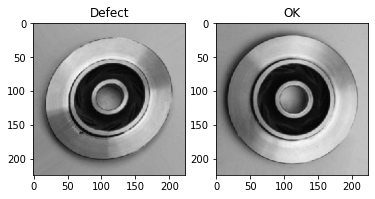

In [12]:
pic1 = plt.subplot(1, 2, 1)
pic1.imshow(X_test[test_def_idx][0].reshape((X_test.shape[1], X_test.shape[2])), cmap="gray")
pic1.set_title("Defect")
pic2 = plt.subplot(1, 2, 2)
pic2.imshow(X_test[test_ok_idx][0].reshape((X_test.shape[1], X_test.shape[2])), cmap="gray")
pic2.set_title("OK")
plt.show()

In [13]:
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top= 'TRUE')

553476096/553467096 [==============================] - 4s 0us/step


In [14]:
model = Sequential()

In [15]:
model.add(InputLayer(input_shape=(224, 224, 1)))
model.add(Conv2D(3, (3,3), padding='same'))

In [16]:
for layer in vgg16_model.layers[:-4]:
  model.add(layer)

for layer in model.layers:
  layer.trainable = False

In [17]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1

In [19]:
es = EarlyStopping(monitor='val_loss', verbose=2, patience=10,  restore_best_weights=True)

In [20]:
# model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', metrics=['binary_accuracy'])
History = model.fit_generator(training_set, steps_per_epoch=training_set.n//BATCH_SIZE, validation_data=val_set, validation_steps=val_set.n//BATCH_SIZE, epochs=100, verbose=2, workers=8, callbacks=[es])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
145/145 - 190s - loss: 0.4020 - binary_accuracy: 0.8268 - val_loss: 0.3862 - val_binary_accuracy: 0.8261 - 190s/epoch - 1s/step
Epoch 2/100
145/145 - 65s - loss: 0.2057 - binary_accuracy: 0.9180 - val_loss: 0.1282 - val_binary_accuracy: 0.9667 - 65s/epoch - 447ms/step
Epoch 3/100
145/145 - 65s - loss: 0.1574 - binary_accuracy: 0.9419 - val_loss: 0.0967 - val_binary_accuracy: 0.9682 - 65s/epoch - 449ms/step
Epoch 4/100
145/145 - 65s - loss: 0.1302 - binary_accuracy: 0.9538 - val_loss: 0.0603 - val_binary_accuracy: 0.9824 - 65s/epoch - 450ms/step
Epoch 5/100
145/145 - 65s - loss: 0.1114 - binary_accuracy: 0.9597 - val_loss: 0.0429 - val_binary_accuracy: 0.9899 - 65s/epoch - 451ms/step
Epoch 6/100
145/145 - 65s - loss: 0.1018 - binary_accuracy: 0.9662 - val_loss: 0.0429 - val_binary_accuracy: 0.9864 - 65s/epoch - 449ms/step
Epoch 7/100
145/145 - 65s - loss: 0.0856 - binary_accuracy: 0.9701 - val_loss: 0.0412 - val_binary_accuracy: 0.9889 - 65s/epoch - 449ms/step
Epoch 8/100
14

In [21]:
model.save("/content/drive/MyDrive/Anomaly detection/casting_model.h5")

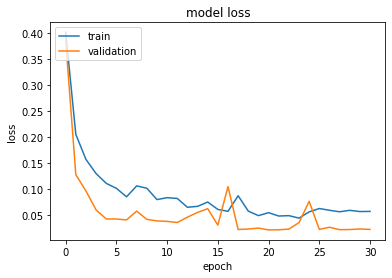

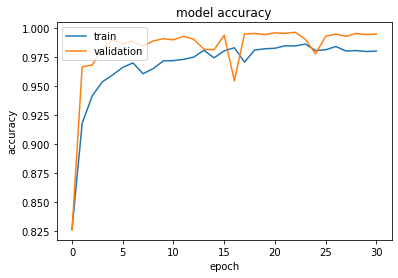

In [22]:
# Loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Accuracy plot 
plt.plot(History.history['binary_accuracy'])
plt.plot(History.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
# Evaluation 1 - Training data
scores_train = model.evaluate(training_set, steps=training_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_train[1], 3))

145/145 [==============================] - 47s 322ms/step - loss: 0.0195 - binary_accuracy: 0.9963
Accuracy:  0.996


In [24]:
# Evaluation 2 - Validataion data
scores_val = model.evaluate(val_set, steps=val_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_val[1], 3))

62/62 [==============================] - 20s 317ms/step - loss: 0.0223 - binary_accuracy: 0.9955
Accuracy:  0.995


In [25]:
pred_probs = model.predict_generator(test_set, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


23/23 [==============================] - 14s 618ms/step


In [26]:
predictions = pred_probs > 0.5
predictions = np.squeeze(predictions, axis=-1).astype("int32")

In [27]:
true = test_set.classes

In [28]:
confusion_matrix(true, predictions)

array([[262,   0],
       [  6, 447]])

In [29]:
print(classification_report(true, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.978     1.000     0.989       262
           1      1.000     0.987     0.993       453

    accuracy                          0.992       715
   macro avg      0.989     0.993     0.991       715
weighted avg      0.992     0.992     0.992       715



In [30]:
from sklearn.metrics import roc_auc_score

In [31]:
test_auc = roc_auc_score(true, pred_probs)

In [32]:
true_probs = [0 for _ in range(len(true))]

In [33]:
from matplotlib import pyplot

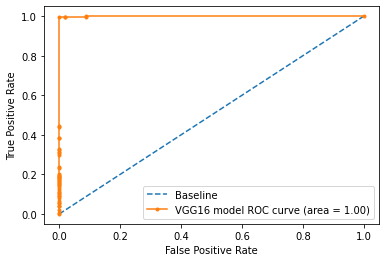

In [34]:
# calculate roc curves
true_fpr, true_tpr, _ = roc_curve(true, true_probs)
pred_fpr, pred_tpr, _ = roc_curve(true, pred_probs)

# plot the roc curve for the model
pyplot.plot(true_fpr, true_tpr, linestyle='--', label='Baseline')
pyplot.plot(pred_fpr, pred_tpr, marker='.', label='VGG16 model ROC curve (area = %0.2f)' % test_auc)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc="lower right")
# show the plot
pyplot.show()

In [35]:
def Grad_CAM_savepictures(file_index, model):

  def loss(output):
    L = y_train[file_index].astype(np.uint8)
    return (output[0][L-1])
    
  # def model_modifier(m):
  #   m.layers[-1].activation = tf.keras.activations.linear
  #   return m
  replace2linear = ReplaceToLinear()

  # Create Gradcam object
  gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
  originalimage = X_train[file_index][:,:,:]
  originalimage = originalimage.reshape((1, originalimage.shape[0], originalimage.shape[1], 1))

  # Generate heatmap with GradCAM
  cam = gradcam(loss, originalimage, penultimate_layer=-1)
  cam = normalize(cam)

  #overlap image
  ax1 = plt.subplot(1, 2, 1)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(X_train[file_index].reshape((X_train.shape[1], X_train.shape[2])),cmap="gray")
  ax1.imshow(heatmap.reshape((X_train.shape[1], X_train.shape[2], 3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM")

  gradcam = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)
  cam = gradcam(loss, originalimage, penultimate_layer=-1)
  cam = normalize(cam)

  ax1 = plt.subplot(1, 2, 2)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(X_train[file_index].reshape((X_train.shape[1],X_train.shape[2])), cmap="gray")
  ax1.imshow(heatmap.reshape((X_train.shape[1], X_train.shape[2], 3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM++")

  plt.show()

In [36]:
train_def_pic = train_def_idx[0][0]
train_ok_pic = train_ok_idx[0][0]

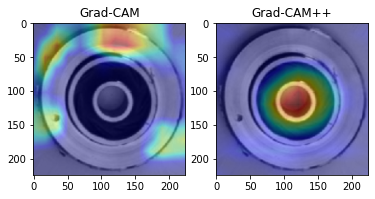

In [37]:
# Defect Grad-CAM & Grad-CAM++
Grad_CAM_savepictures(train_def_pic, model)

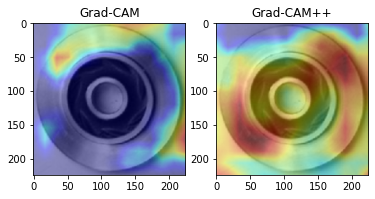

In [38]:
# OK Grad-CAM & Grad-CAM++
Grad_CAM_savepictures(train_ok_pic, model)